In [1]:
import os

import freud
import hoomd
import matplotlib
import matplotlib.pyplot as plt
import mdtraj
import numpy as np
import parmed as pmd
import rowan
import simtk.unit as unit
from mbuild.formats.hoomd_forcefield import create_hoomd_forcefield
from simtk.openmm import app

import openpathsampling as paths
import openpathsampling.engines.hoomd as ops_hoomd

initial_pdb = os.path.join("..", "resources", "AD_initial_frame.pdb")

In [2]:
forcefield = app.ForceField("amber96.xml", "tip3p.xml")
pdb = app.PDBFile(initial_pdb).topology
system = forcefield.createSystem(
    topology=pdb,
    nonbondedMethod=app.PME,
    nonbondedCutoff=1.0 * unit.nanometers,
    constraints=app.HBonds,
    rigidWater=True,
    ewaldErrorTolerance=0.0005,
)
pmd_structure = pmd.openmm.load_topology(
    topology=pdb,
    system=system,
    xyz=initial_pdb,
)

In [3]:
# Set up HOOMD reference unit system: AKMA (Angstrom, Kilocalories/mol, Atomic mass unit)
energy = unit.kilocalorie_per_mole
length = unit.angstrom
mass = unit.amu
time = np.sqrt(1.0 * mass * length * length / energy)

# parmed also uses the AKMA system
ref_akma_units = dict(
    ref_distance=1.0 * length / unit.angstrom,
    ref_mass=1.0 * unit.amu / unit.amu,
    ref_energy=1.0 * unit.kilocalorie_per_mole / energy,
)
r_cut = 1.0 * unit.nanometers / length

print(ref_akma_units)

snapshot, forcefield, ref_vals = create_hoomd_forcefield(
    structure=pmd_structure,
    **ref_akma_units,
    r_cut=r_cut,
    pppm_kwargs={"Nx": 24, "Ny": 24, "Nz": 24, "order": 6},
)

device = hoomd.device.auto_select()
sim = hoomd.Simulation(device=device, seed=123)

# Set up units for simulation kT and dt
kT = (
    800.0  # originally 500.0
    * unit.constants.BOLTZMANN_CONSTANT_kB
    * unit.kelvin
    / energy
    * unit.constants.AVOGADRO_CONSTANT_NA
)
dt = 2.0 * unit.femtosecond / time
print(f"{dt=:.5f}", f"{kT=:.5f}")

particle_filter = hoomd.filter.Rigid(("center", "free"))
methods = [hoomd.md.methods.Langevin(filter=particle_filter, kT=kT)]
sim.operations.integrator = hoomd.md.Integrator(
    dt=dt, methods=methods, forces=forcefield
)
gsd_writer = hoomd.write.GSD(
    "dump.gsd",
    trigger=hoomd.trigger.Periodic(10),
    mode="wb",
    dynamic=["property", "momentum"],
)
sim.operations += gsd_writer
thermo = hoomd.md.compute.ThermodynamicQuantities(filter=particle_filter)
sim.operations += thermo

{'ref_distance': 1.0, 'ref_mass': 1.0, 'ref_energy': 1.0}
Processing LJ and QQ
Processing 1-4 interactions, adjusting neighborlist exclusions
Processing harmonic bonds
Bond with no bondtype detected, setting coefficients to 0
Bond with no bondtype detected, setting coefficients to 0
Bond with no bondtype detected, setting coefficients to 0
Bond with no bondtype detected, setting coefficients to 0
Processing harmonic angles
Processing periodic torsions
dt=0.04091 kT=1.58976


In [4]:
# To-do: perform energy minimization here

In [5]:
# Constrain hydrogen bonds in alanine dipeptide
indices = np.arange(snapshot.particles.N)
snapshot.constraints.N = 0
box = freud.Box.from_box(snapshot.configuration.box)
for H_type in ("H1", "H2", "H3"):
    H_index = snapshot.particles.types.index(H_type)
    H_ids = indices[snapshot.particles.typeid == H_index]
    for H_id in H_ids:
        for bond_ids in snapshot.bonds.group:
            if H_id in bond_ids:
                constraint_id = snapshot.constraints.N
                snapshot.constraints.N += 1
                snapshot.constraints.group[constraint_id] = bond_ids
                positions = snapshot.particles.position[bond_ids]
                bond_length = np.linalg.norm(box.wrap(positions[1] - positions[0]))
                snapshot.constraints.value[constraint_id] = bond_length
constrain = hoomd.md.constrain.Distance(tolerance=0.1)
sim.operations.integrator.constraints.append(constrain)

In [6]:
# Make water rigid
water_O_index = snapshot.particles.types.index("O2")
water_H_index = snapshot.particles.types.index("H4")
indices = np.arange(snapshot.particles.N)
water_O_ids = indices[snapshot.particles.typeid == water_O_index]
water_H_ids = indices[snapshot.particles.typeid == water_H_index]
snapshot.particles.body[water_O_ids] = water_O_ids
snapshot.particles.body[water_H_ids] = np.repeat(water_O_ids, 2)
box = freud.Box.from_box(snapshot.configuration.box)

bond_lengths = []
bond_angles = []
for O in water_O_ids:
    positions = snapshot.particles.position[O : O + 3]
    # print(positions)
    OH1 = box.wrap(positions[1] - positions[0])
    OH1_length = np.linalg.norm(OH1)
    bond_lengths.append(OH1_length)

    OH2 = box.wrap(positions[2] - positions[0])
    OH2_length = np.linalg.norm(OH2)
    bond_lengths.append(OH2_length)

    HOH_angle = np.arccos(np.dot(OH1 / OH1_length, OH2 / OH2_length))
    bond_angles.append(HOH_angle)

# Create a rigid water molecule in the x-y plane, symmetric about the x axis.
OH_length = np.mean(bond_lengths)
HOH_angle = np.mean(bond_angles)
OH1_rigid_position = OH_length * np.array(
    [np.cos(HOH_angle / 2), np.sin(HOH_angle / 2), 0]
)
OH2_rigid_position = OH_length * np.array(
    [np.cos(HOH_angle / 2), -np.sin(HOH_angle / 2), 0]
)
H_charge = np.mean(snapshot.particles.charge[water_H_ids])
O_mass = np.mean(snapshot.particles.mass[water_O_ids])
H_mass = np.mean(snapshot.particles.mass[water_H_ids])
rigid_body_positions = np.array([[0, 0, 0], OH1_rigid_position, OH2_rigid_position])
moment_of_inertia = np.zeros((3, 3))
for m, r in zip((O_mass, H_mass, H_mass), rigid_body_positions):
    moment_of_inertia += m * (np.eye(3) * np.dot(r, r) - np.outer(r, r))
# Ensure that the inertia tensor is diagonal
assert (
    np.count_nonzero(moment_of_inertia - np.diag(np.diagonal(moment_of_inertia))) == 0
)
moment_of_inertia = np.diag(moment_of_inertia)
water_mass = np.sum((O_mass, H_mass, H_mass))

# Assign rigid body parameters to each water oxygen
for O in water_O_ids:
    positions = snapshot.particles.position[O : O + 3]
    OH1 = box.wrap(positions[1] - positions[0])
    OH2 = box.wrap(positions[2] - positions[0])
    target_positions = np.array([[0, 0, 0], OH1, OH2])
    rotation, translation = rowan.mapping.davenport(
        rigid_body_positions, target_positions
    )
    assert np.isclose(np.linalg.norm(translation), 0, atol=1e-2)
    snapshot.particles.orientation[O] = rotation
    snapshot.particles.moment_inertia[O] = moment_of_inertia
    snapshot.particles.mass[O] = water_mass

rigid = hoomd.md.constrain.Rigid()
rigid.body["O2"] = {
    "constituent_types": ["H4", "H4"],
    "positions": [OH1_rigid_position, OH2_rigid_position],
    "orientations": [(1.0, 0.0, 0.0, 0.0), (1.0, 0.0, 0.0, 0.0)],
    "charges": [H_charge, H_charge],
    "diameters": [1.0, 1.0],
}
sim.operations.integrator.rigid = rigid

In [7]:
sim.create_state_from_snapshot(snapshot)
sim.state.thermalize_particle_momenta(filter=particle_filter, kT=kT)
hoomd.write.GSD.write(sim.state, "init.gsd")

In [8]:
engine_options = {"n_frames_max": 2000, "n_steps_per_frame": 10}
engine = ops_hoomd.Engine(
    simulation=sim,
    options=engine_options,
)

In [9]:
# define the CVs
mdtraj_topology = mdtraj.load(initial_pdb).topology
mdtraj_topology = paths.engines.MDTrajTopology(mdtraj_topology)
psi = paths.MDTrajFunctionCV(
    "psi", mdtraj.compute_dihedrals, topology=mdtraj_topology, indices=[[6, 8, 14, 16]]
).enable_diskcache()
phi = paths.MDTrajFunctionCV(
    "phi", mdtraj.compute_dihedrals, topology=mdtraj_topology, indices=[[4, 6, 8, 14]]
).enable_diskcache()

In [10]:
# define the states
deg = 180.0 / np.pi
C_7eq = (
    paths.PeriodicCVDefinedVolume(
        phi,
        lambda_min=-180 / deg,
        lambda_max=0 / deg,
        period_min=-np.pi,
        period_max=np.pi,
    )
    & paths.PeriodicCVDefinedVolume(
        psi,
        lambda_min=100 / deg,
        lambda_max=200 / deg,
        period_min=-np.pi,
        period_max=np.pi,
    )
).named("C_7eq")
# similarly, without bothering with the labels:
alpha_R = (
    paths.PeriodicCVDefinedVolume(phi, -180 / deg, 0 / deg, -np.pi, np.pi)
    & paths.PeriodicCVDefinedVolume(psi, -100 / deg, 0 / deg, -np.pi, np.pi)
).named("alpha_R")

In [11]:
visit_all = paths.VisitAllStatesEnsemble([C_7eq, alpha_R])
trajectory = engine.generate(engine.current_snapshot, [visit_all.can_append])

Ran 744 frames. Found states [alpha_R,C_7eq]. Looking for [].


In [12]:
def make_phi_psi_figure():
    fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi)
    ax.set_xlabel("$\\phi$")
    ax.set_ylabel("$\\psi$")
    ax.add_patch(
        matplotlib.patches.Rectangle(
            (-np.pi, 100 / deg),
            np.pi,
            180 / deg,
            alpha=0.1,
            label="$C_7^{eq}$ volume",
            facecolor="b",
        )
    )
    ax.add_patch(
        matplotlib.patches.Rectangle(
            (-np.pi, -np.pi),
            np.pi,
            200 / deg % np.pi,
            alpha=0.1,
            label=None,
            facecolor="b",
        )
    )
    ax.add_patch(
        matplotlib.patches.Rectangle(
            (-np.pi, -100 / deg),
            np.pi,
            100 / deg,
            alpha=0.1,
            label="$\\alpha_R$ volume",
            facecolor="r",
        )
    )
    for axis in (ax.xaxis, ax.yaxis):
        axis.set_major_locator(
            matplotlib.ticker.FixedLocator([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi])
        )
        axis.set_major_formatter(
            matplotlib.ticker.FixedFormatter(
                ["$-\\pi$", "$-\\pi/2$", "$0$", "$\\pi/2$", "$\\pi$"]
            )
        )
    ax.legend()
    return fig, ax

## Plotting the trajectory

In [13]:
# create a network so we can use its ensemble to obtain an initial trajectory
# use all-to-all because initial traj can be A->B or B->A; will be reversed
tmp_network = paths.TPSNetwork.from_states_all_to_all([C_7eq, alpha_R])

In [14]:
# take the subtrajectory matching the ensemble (only one ensemble, only one subtraj)
subtrajectories = []
for ens in tmp_network.analysis_ensembles:
    subtrajectories += ens.split(trajectory)
print(subtrajectories)

[Trajectory[9]]


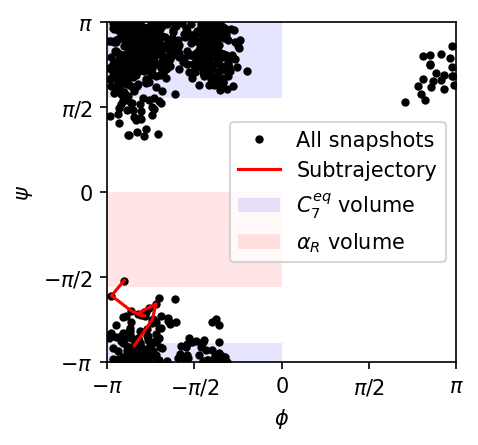

In [15]:
fig, ax = make_phi_psi_figure()
ax.plot(phi(trajectory), psi(trajectory), "k.", label="All snapshots")
ax.plot(phi(subtrajectories[0]), psi(subtrajectories[0]), "r", label="Subtrajectory")
ax.legend()
plt.show()

## Setting up the normal temperature engine

We'll create another engine that uses a 300K integrator, and equilibrate to a 300K path from the 500K path.

In [16]:
normal_T = 300
kT = (
    normal_T
    * unit.constants.BOLTZMANN_CONSTANT_kB
    * unit.kelvin
    / energy
    * unit.constants.AVOGADRO_CONSTANT_NA
)

engine.simulation.operations.integrator.methods[0].kT = kT

## Using TPS to equilibrate

This is, again, a simple path sampling setup. We use the same `TPSNetwork` we'll use later, and only shooting moves. One the initial conditions are correctly set up, we run one step at a time until the initial trajectory is decorrelated.

This setup of a path sampler always consists of defining a `network` and a `move_scheme`. See toy model notebooks for further discussion.

In [17]:
network = paths.TPSNetwork(initial_states=C_7eq, final_states=alpha_R).named(
    "tps_network"
)
scheme = paths.OneWayShootingMoveScheme(
    network, selector=paths.UniformSelector(), engine=engine
).named("equil_scheme")

The move scheme's `initial_conditions_from_trajectories` method will take whatever input you give it and try to generate valid initial conditions. This includes looking for subtrajectories that satisfy the ensembles you're sampling, as well as reversing the trajectory. If it succeeds, you'll see the message "No missing ensembles. No extra ensembles." It's also a good practice to use `scheme.assert_initial_conditions` to ensure that your initial conditions are valid. This will halt a script if the initial conditions are not valid.

In [18]:
# make subtrajectories into initial conditions (trajectories become a sampleset)
initial_conditions = scheme.initial_conditions_from_trajectories(subtrajectories)

No missing ensembles.
No extra ensembles.


In [19]:
# check that initial conditions are valid and complete (raise AssertionError otherwise)
scheme.assert_initial_conditions(initial_conditions)

We can create a `StepVisualizer2D`, which plays the simulation as it is running. It requires CVs for the $x$ direction and the $y$ direction, as well as bounds of the plot. You can set the `background` attribute to an existing matplotlib `Figure`, and the simulation will plot on top of that. See the toy model MSTIS example for an example of that.

This isn't necessary, and isn't even a useful for long simulations (which typically won't be in an interactive notebook), but it can be fun!

In [20]:
sampler = paths.PathSampling(
    storage=paths.Storage("ad_tps_equil.nc", "w", template=None),
    move_scheme=scheme,
    sample_set=initial_conditions,
)

In [21]:
# initially, these trajectories are correlated (actually, identical)
# once decorrelated, we have a (somewhat) reasonable 300K trajectory
initial_conditions[0].trajectory.is_correlated(sampler.sample_set[0].trajectory)

True

In [22]:
sampler.run_until_decorrelated()

notice(2): charge.pppm: RMS error: 0.000492026
Step 13: All trajectories decorrelated!


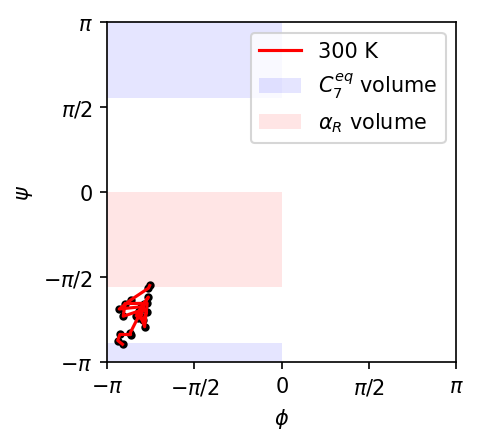

In [23]:
fig, ax = make_phi_psi_figure()
traj = sampler.sample_set[0].trajectory
ax.plot(phi(traj), psi(traj), "k.")
ax.plot(phi(traj), psi(traj), "r", label=f"{normal_T} K")
ax.legend()
plt.show()

In [24]:
# now we have decorrelated: no frames are in common
initial_conditions[0].trajectory.is_correlated(sampler.sample_set[0].trajectory)

False

In [25]:
# run an extra 10 to decorrelate a little further
sampler.run(10)

Working on Monte Carlo cycle number 22
Running for 14 seconds -  1.60 seconds per step
Estimated time remaining: 1 second
notice(2): charge.pppm: RMS error: 0.000492026
DONE! Completed 22 Monte Carlo cycles.


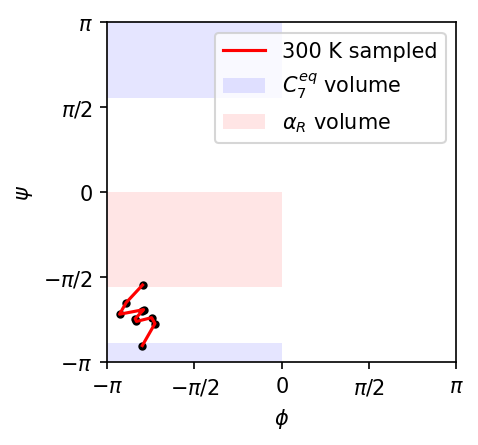

In [26]:
fig, ax = make_phi_psi_figure()
traj = sampler.sample_set[0].trajectory
ax.plot(phi(traj), psi(traj), "k.")
ax.plot(phi(traj), psi(traj), "r", label=f"{normal_T} K sampled")
ax.legend()
plt.show()

In [27]:
sampler.storage.close()